In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as scp
import seaborn as sns

### The Tips Dataset
We want to study effects of the day of the week on the amount of tips at a restaurant. 
There is no control group and treatment group as this is just an observational study.

We will use will be taking one day(Thursday) as reference/control.

In [3]:
tips = sns.load_dataset('tips')

In [4]:
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


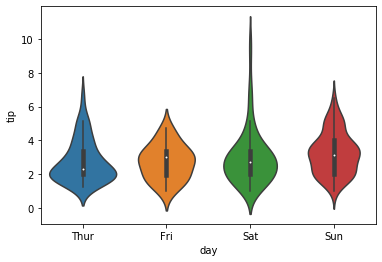

In [5]:
sns.violinplot(x='day', y='tip', data=tips)

In [6]:
import pandas as pd

In [7]:
y = tips['tip'].values
idx = pd.Categorical(tips['day']).codes

In [9]:
import pymc3 as pm

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sds, means]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:18<00:00, 609.65draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ebe2e0f28>,
      dtype=object)

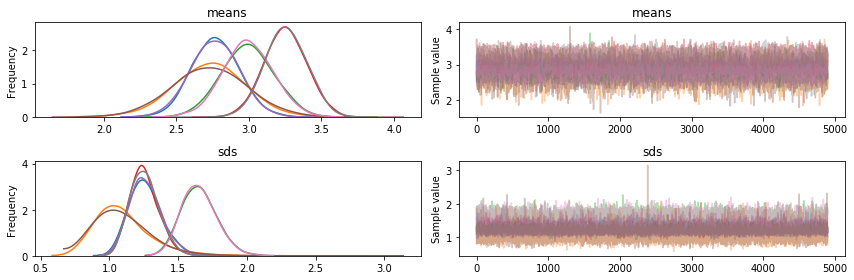

In [10]:
with pm.Model() as group_model:
    means = pm.Normal('means', mu=0, sd=10, shape = len(set(idx)))
    sds = pm.HalfNormal('sds', sd=10, shape = len(set(idx)))
    
    y = pm.Normal('y', mu=means[idx], sd= sds[idx], observed=y)
    
    trace_gm = pm.sample(5000)
chain_gm = trace_gm[100:]
pm.traceplot(chain_gm)

We want to compare the posterior against 0 ( no difference)

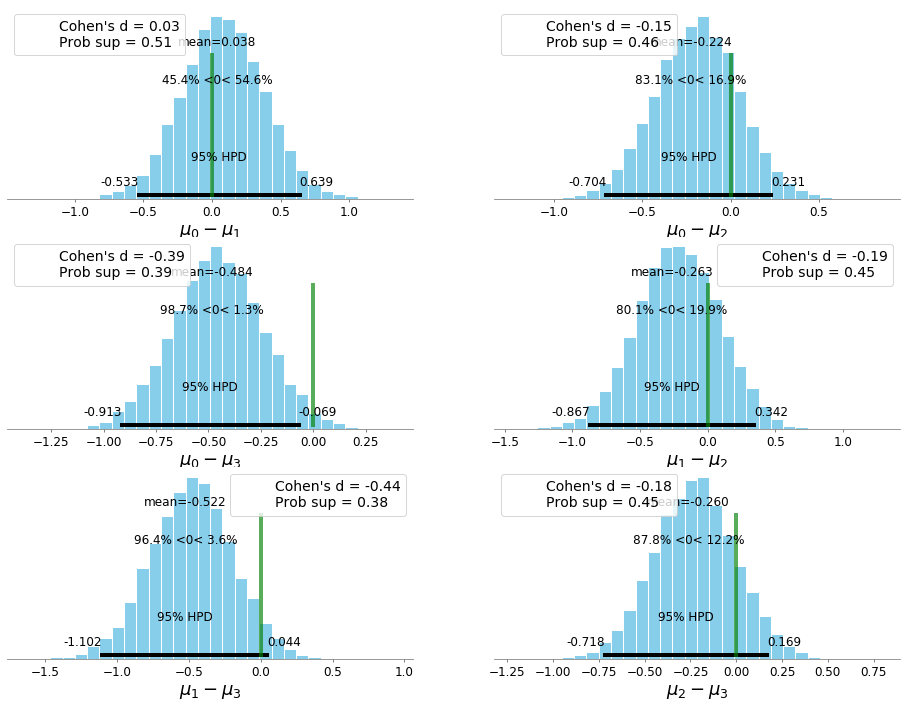

In [15]:
dist = scp.stats.norm()
_, ax = plt.subplots(3, 2, figsize=(16, 12))

comparison = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0,1)]

for (i,j), (k,l) in zip(comparison, pos):
    mean_diff = chain_gm['means'][:, i] - chain_gm['means'][:, j]
    d_cohen = (mean_diff/np.sqrt((chain_gm['sds'][:,i]**2 + chain_gm['sds'][:,j]**2)/2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    
    pm.plot_posterior(mean_diff, ref_val=0, ax=ax[k, l], color='skyblue')
    ax[k,l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps), alpha=0)
    ax[k,l].set_xlabel('$\mu_{} - \mu_{}$'.format(i, j), fontsize=18)
    ax[k,l].legend(loc=0, fontsize=14)

### Cohen's d
A common way to measure the effect size(at least in some feilds such as psychology) is *Cohen's d*:
$$ \frac{\mu_1 - \mu_2}{\sqrt \frac{\sigma_1^2 + \sigma_2^2}{2}}$$

In other words it is difference between means with respect to the average standard deviation of both the groups. 

### Probability of Superiority
It is defined as probability that a data point from one group has a larger value than one taken from the group. If we assume that the distribution of the groups are normal, we can compute probability of superiory from the Cohen's d value as :
$$ ps = \Phi (\frac {\delta} {\sqrt 2} ) $$

where $\delta$ is Cohen's d value and $\Phi$ is cumulative normal distribution.